In [3]:
%matplotlib inline

import sys
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from outliers import ddc_outlier
from sklearn.metrics import f1_score

import multiprocessing
import tempfile
import os
from joblib import Parallel, delayed
from joblib.pool import has_shareable_memory
cpuN = multiprocessing.cpu_count()

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('data/prescriptions_sample.csv.gz', compression='gzip')

In [4]:
medications = outliers.getOverdoseMedications(prescription)
medications.shape

(21,)

In [5]:
def computeClf(X,Y,epsilon,scores):
    clf = ddc_outlier(alpha=epsilon,metric='jaccard')
    clf.fit(X)
    y_pred = clf.predict(X)

    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1

    f = f1_score(y_pred, Y)
    scores[int(epsilon*100)] = f

In [11]:
scores_df = pd.DataFrame()

folder = tempfile.mkdtemp()
score_name = os.path.join(folder, 'score')

ep_range = np.arange(0.01,1.0,0.01)

for med in medications:

    X, Y = outliers.getPrescriptions(prescription, med)
    print(med + ': ',len(X))

    scores = np.memmap(score_name, dtype=float, shape=(150), mode='w+')
    Parallel(n_jobs=cpuN)(delayed(computeClf)(X,Y,epsilon,scores)
                   for epsilon in ep_range)
    
    for ep in ep_range:
        idx = int(ep*100)
        scores_df.loc[med,ep] = scores[idx]
    
    epsilon = scores_df.idxmax(1).values[0]
    f1 = scores_df.max(1).values[0]

ALOPURINOL:  4729
AMPICILINA:  7226
ANLODIPINO:  10392
BISACODIL:  9483
CETOPROFENO:  10907
CLORETO:  5593
DIAZEPAM:  9030
DICLOFENACO:  5559
DOXAZOSINA:  6280
ENALAPRIL:  9585
ENOXAPARINA:  7666
HIDRALAZINA:  6056
LOPERAMIDA:  4957
MORFINA:  5362
PARACETAMOL:  10811
POLIMIXINA:  7257
RISPERIDONA:  5431
SULFAMETOXAZOL:  7086
TENOFOVIR:  4518
VARFARINA:  6419
VITAMINAS:  5766


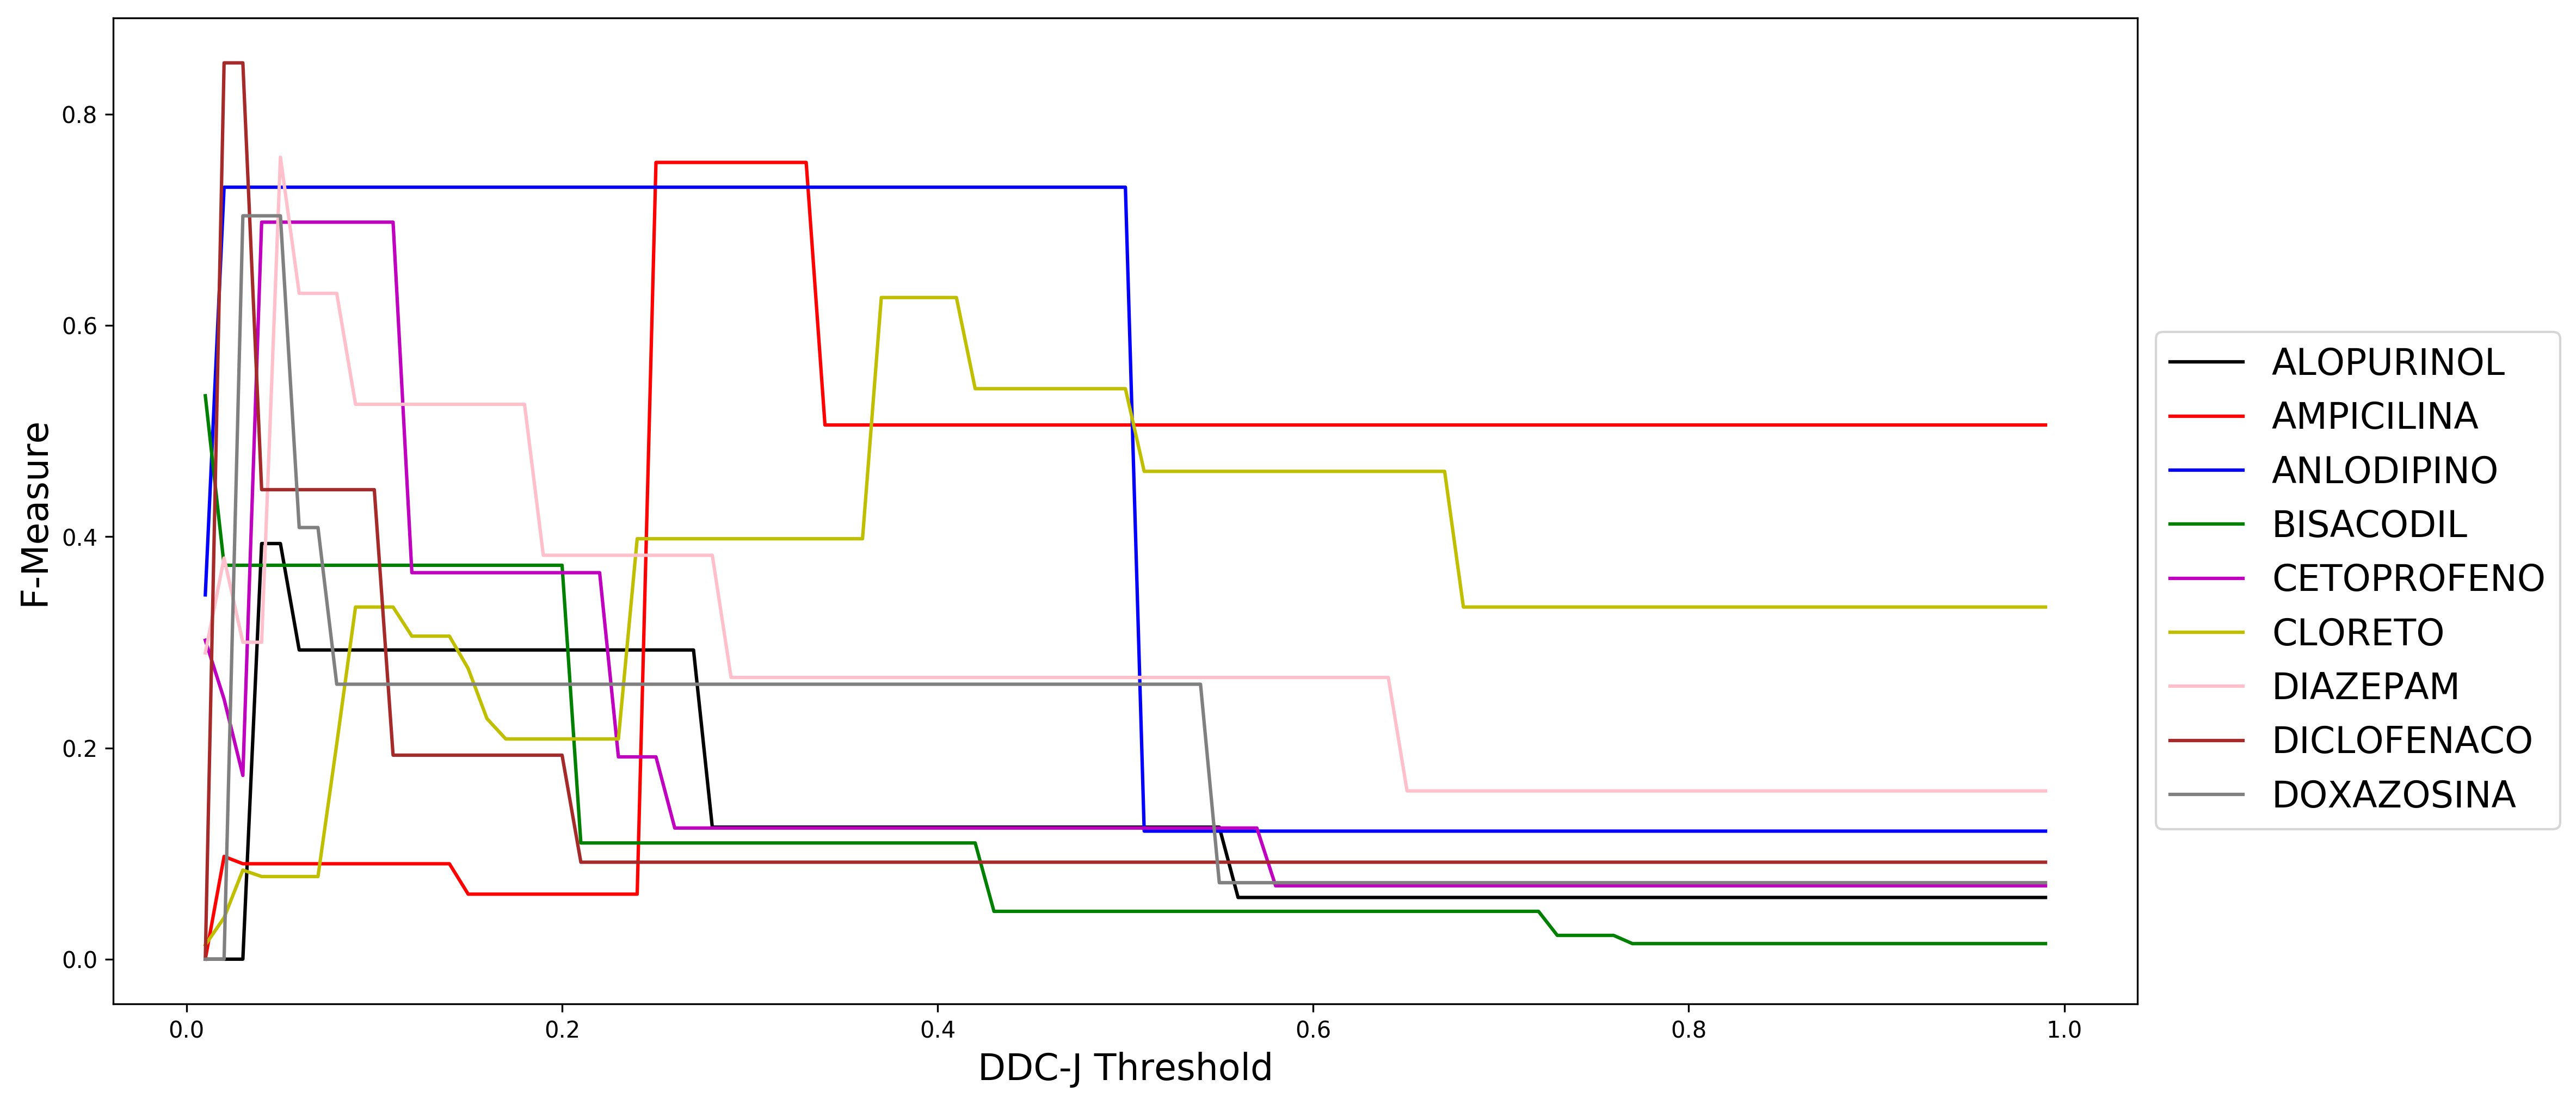

In [14]:
plt.figure(figsize=(16, 8), dpi= 300)
colors = ['k','r','b','g','m','y','pink','brown','gray']
i = 0
for med in scores_df.index:
    plt.plot(np.asarray(scores_df.columns),np.asarray(scores_df.loc[med].values), c=colors[i],label=med)
    i += 1
    if i > 8:
        break
    
plt.legend(bbox_to_anchor=(1, 0.70), fontsize=16)
plt.xlabel('DDC-J Threshold', fontsize=16)
plt.ylabel('F-Measure', fontsize=16)
plt.show()

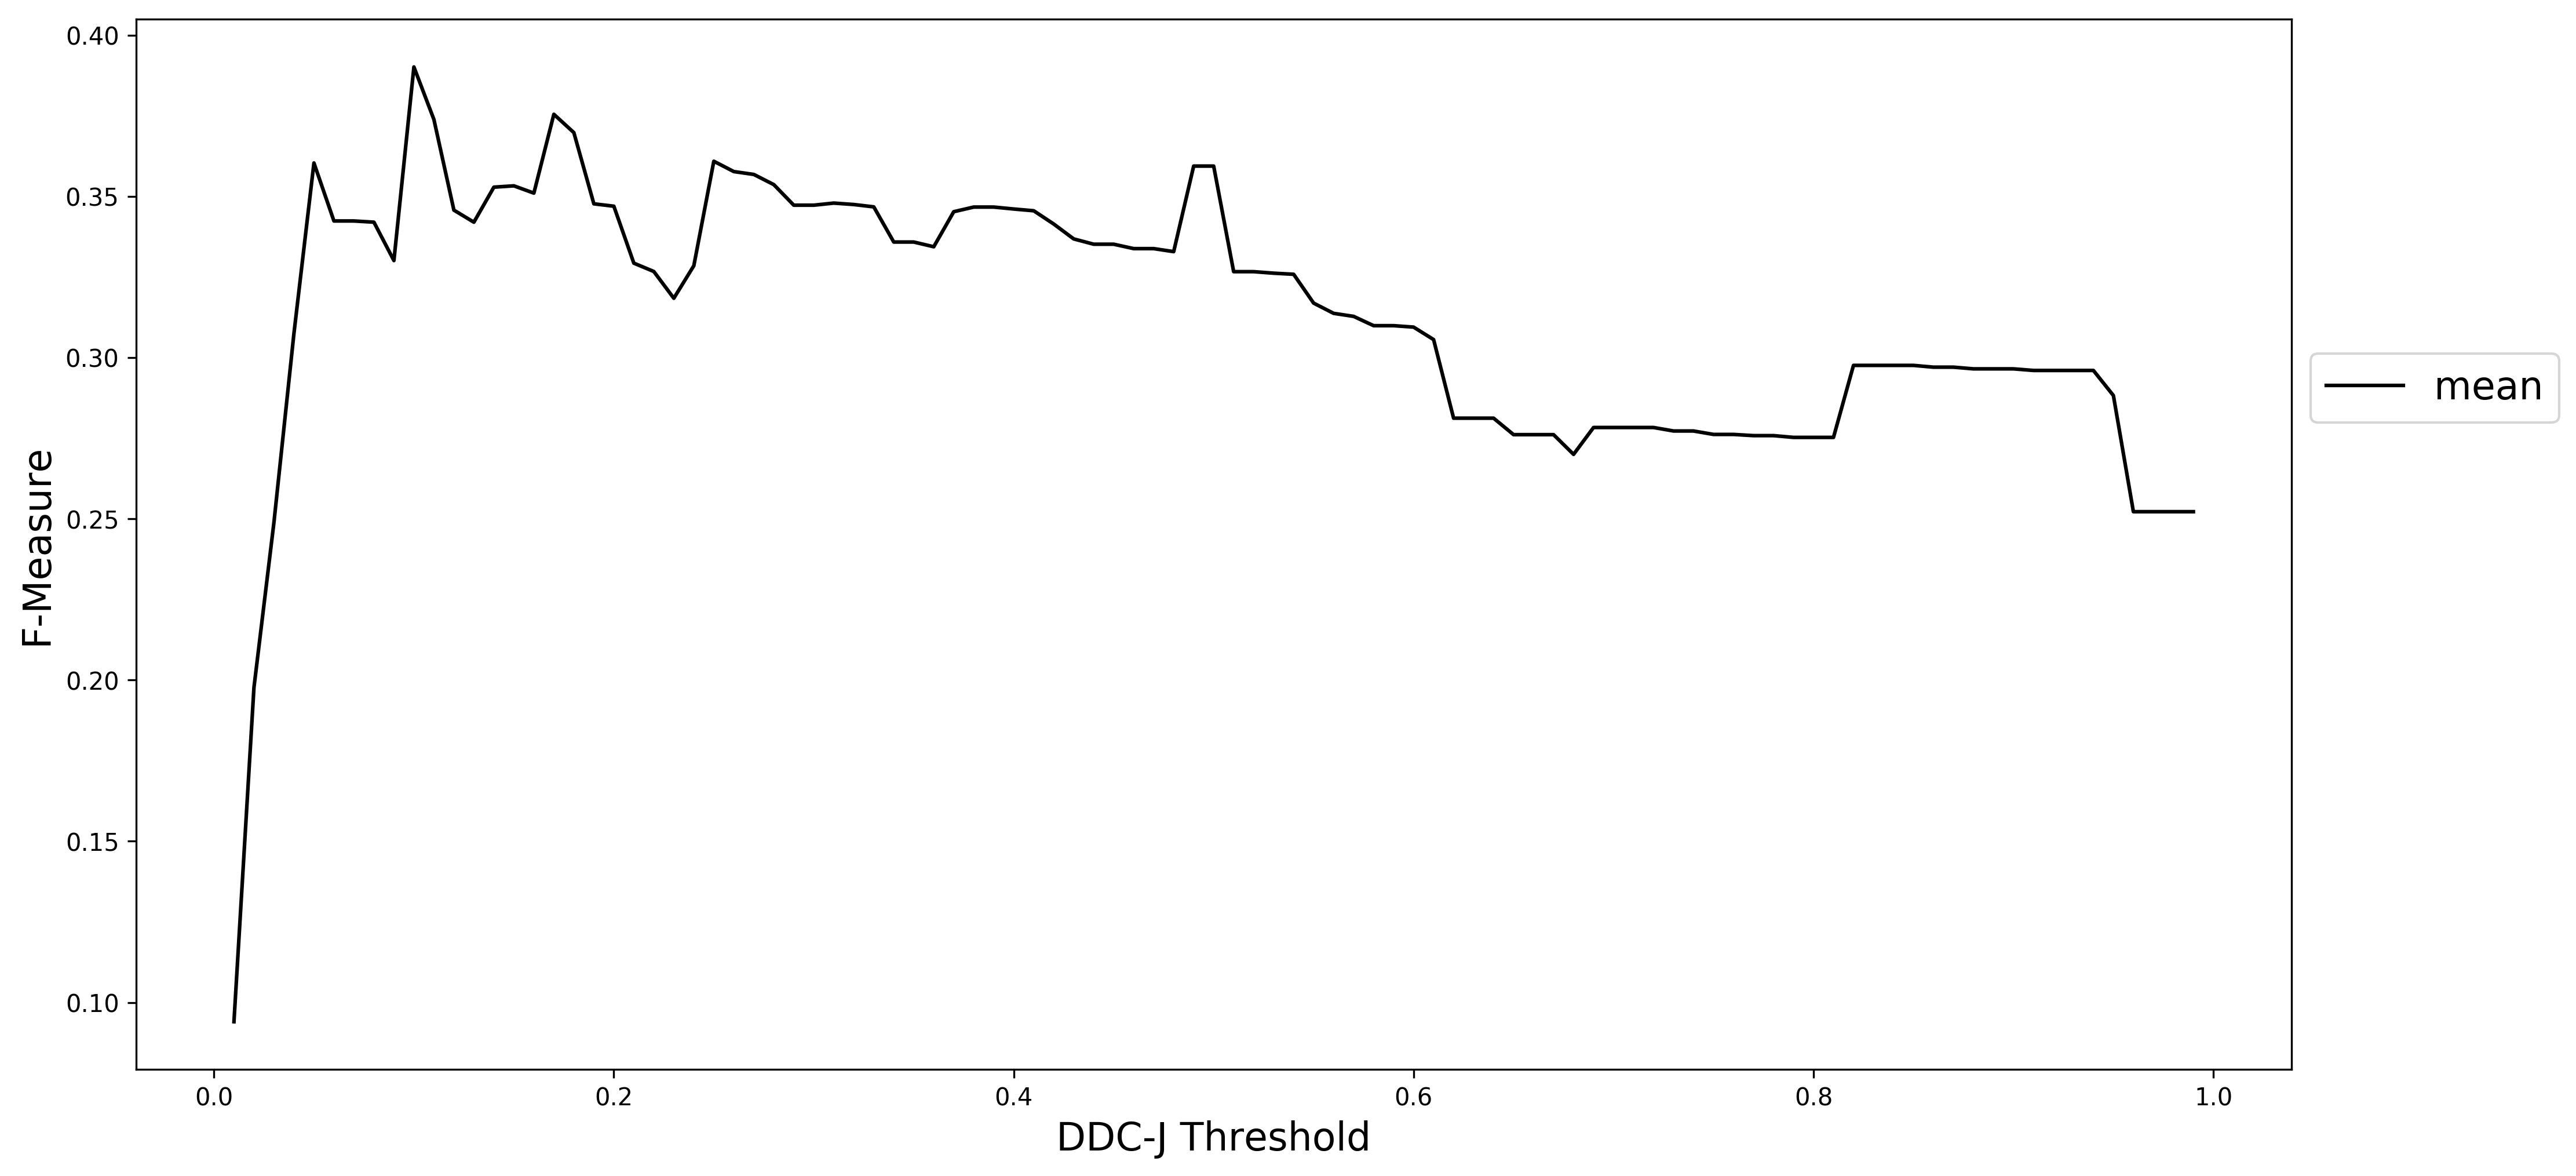

In [13]:
plt.figure(figsize=(16, 8), dpi= 300)
plt.plot(np.asarray(scores_df.mean(0).index),np.asarray(scores_df.mean(0).values), c='k',label='mean')
plt.legend(bbox_to_anchor=(1, 0.70), fontsize=16)
plt.xlabel('DDC-J Threshold', fontsize=16)
plt.ylabel('F-Measure', fontsize=16)
plt.show()